## Cross-validation for PU and SVM models

In [1]:
use_extracted_data = False


In [2]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulearn.bagging import BaggingPuClassifier
from sklearn.base import clone
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from lib.check_files import check_prepared_data
from lib.cv import perform_cv
from lib.pu import (
    BASE_MODELS,
    PU_PARAMS,
    get_xy,
    downsample_unlabelled,
)

# Suppress FutureWarning for some versions of Scikit-learn
%env PYTHONWARNINGS=ignore::FutureWarning

warnings.simplefilter("ignore", FutureWarning)


env: PYTHONWARNINGS=ignore::FutureWarning


In [3]:
# Random seed for reproducibility
random_seed = 1234

# Number of jobs used to train models
n_jobs = 8

rf_params = {"random_state": random_seed}
pu_params = {
    "n_jobs": n_jobs,
    "random_state": random_seed,
    **PU_PARAMS
}


### Load and process training data

In [4]:
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir, verbose=True)

figures_dir = "supplementary_figures"
os.makedirs(figures_dir, exist_ok=True)

data_filename = os.path.join(data_dir, "training_data.csv")
data = pd.read_csv(data_filename)

# Restrict unlabelled training data to the Americas
data = data[data["region"].isin({"NAm", "SAm"})]

data = downsample_unlabelled(data, random_state=random_seed)

data.groupby("label").size()


label
negative      392
positive      190
unlabelled    190
dtype: int64

### Perform cross-validation

In [5]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_seed)
# Scaling not necessary for RF, but kept for consistency
scaler = RobustScaler()

thresh_pu = "auto"
base_model = clone(BASE_MODELS["randomforest"])
base_model.set_params(**rf_params)
model_pu = BaggingPuClassifier(base_model, **pu_params)
model_pu = make_pipeline(clone(scaler), model_pu)
results_pu = perform_cv(
    clf=model_pu,
    data=data,
    cv=cv,
    thresh=thresh_pu,
    random_state=random_seed,
    pu=True,
    verbose=False,
)
results_pu = pd.DataFrame(results_pu)

thresh_svm = "auto"
model_svm = SVC(kernel="rbf", probability=True, random_state=random_seed)
model_svm = make_pipeline(clone(scaler), model_svm)

results_svm = perform_cv(
    clf=model_svm,
    data=data,
    cv=cv,
    thresh=thresh_svm,
    random_state=random_seed,
    pu=False,
    verbose=False,
)
results_svm = pd.DataFrame(results_svm)

results_combined = pd.concat(
    (
        results_pu.assign(method="PU"),
        results_svm.assign(method="SVM"),
    ),
    ignore_index=True,
)


In [6]:
results_combined.groupby(["method", "region"]).mean(numeric_only=True).T


method                     PU                                 SVM              \
region                    All         NAm         SAm         All         NAm   
roc_auc              0.954836    0.979391    0.881470    0.983288    0.948861   
average_precision    0.960759    0.995109    0.829300    0.975712    0.981661   
balanced_accuracy    0.952199    0.955592    0.891653    0.968642    0.921211   
accuracy             0.966658    0.948105    0.976229    0.974574    0.938824   
f1                   0.946314    0.965160    0.851422    0.960413    0.959703   
n_test             116.400000   40.000000   76.400000  116.400000   40.000000   
n_train            273.600000  273.600000  273.600000  465.600000  465.600000   
time_fit             2.021926    2.021926    2.021926    0.022801    0.022801   
time_predict         1.717679    0.848375    0.869304    0.002014    0.000852   
prob_thresh          0.554343    0.554343    0.554343    0.367677    0.367677   

method                         
region                    SAm  
roc_auc              0.999055  
average_precision    0.992687  
balanced_accuracy    0.988849  
accuracy             0.993795  
f1                   0.967959  
n_test              76.400000  
n_train            465.600000  
time_fit             0.022801  
time_predict         0.001161  
prob_thresh          0.367677

### Performance varies by region

In [7]:
stratify = (
    data["region"]
    + "_"
    + data["label"]
)
data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    random_state=random_seed,
    shuffle=True,
    stratify=stratify,
)
data_test = data_test[data_test["label"].isin({"positive", "negative"})]
indices_NA = np.where(data_test["region"] == "NAm")[0]
indices_SA = np.where(data_test["region"] == "SAm")[0]

train_pu = data_train[
    data_train["label"].isin({"positive", "unlabeled", "unlabelled"})
]
x_train_pu, y_train_pu = get_xy(train_pu)
train_svm = data_train[
    data_train["label"].isin({"positive", "negative"})
]
x_train_svm, y_train_svm = get_xy(train_svm)

x_test, y_test = get_xy(data_test)

model_pu = clone(model_pu)
model_pu.fit(x_train_pu, y_train_pu)

model_svm = clone(model_svm)
model_svm.fit(x_train_svm, y_train_svm)

probs_pu = model_pu.predict_proba(x_test)[:, 1]
probs_pu_NA = probs_pu[indices_NA]
probs_pu_SA = probs_pu[indices_SA]

probs_svm = model_svm.predict_proba(x_test)[:, 1]
probs_svm_NA = probs_svm[indices_NA]
probs_svm_SA = probs_svm[indices_SA]

probs_dict = {
    "All": {"PU": probs_pu, "SVM": probs_svm},
    "NA": {"PU": probs_pu_NA, "SVM": probs_svm_NA},
    "SA": {"PU": probs_pu_SA, "SVM": probs_svm_SA},
}
kwargs_dict = {
    "PU": {"color": "blue", "linestyle": "solid"},
    "SVM": {"color": "orange", "linestyle": "dashed"},
}

pd.concat(
    (
        data_train.assign(set="train"),
        data_test.assign(set="test"),
    )
).groupby(["set", "region", "label"]).size()


set    region  label     
test   NAm     negative        9
               positive       31
       SAm     negative       70
               positive        7
train  NAm     negative       36
               positive      124
               unlabelled     87
       SAm     negative      277
               positive       28
               unlabelled     65
dtype: int64

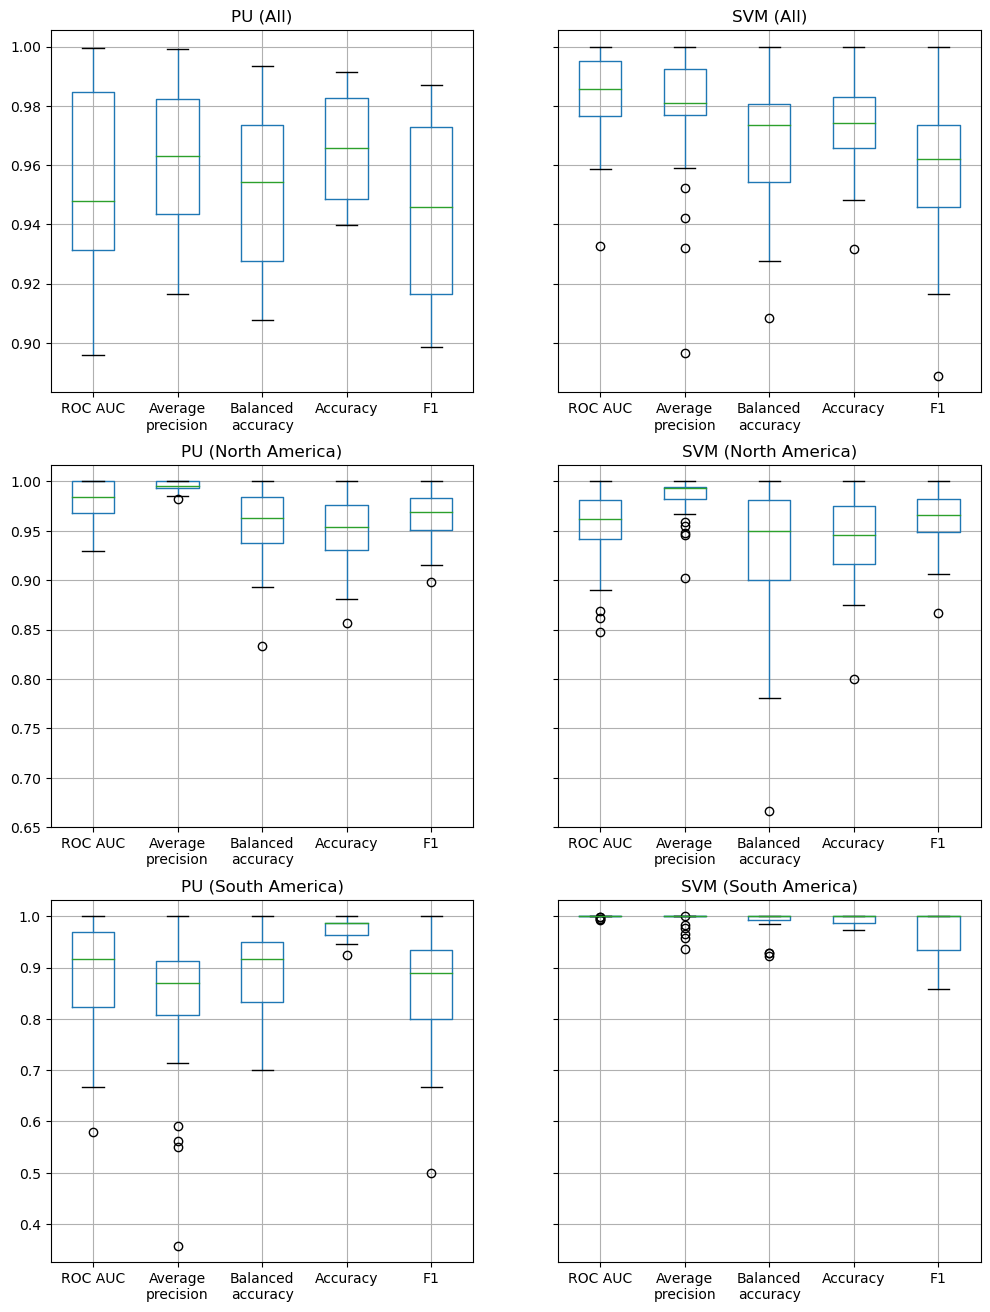

In [8]:
figure_filename = os.path.join(figures_dir, "cv_boxplots")

regions = ("All", "NAm", "SAm")
region_format = {
    "NAm": "North America",
    "SAm": "South America",
}
metric_format = {
    "roc_auc": "ROC AUC",
    "average_precision": "Average\nprecision",
    "balanced_accuracy": "Balanced\naccuracy",
    "accuracy": "Accuracy",
    "f1": "F1",
}
drop = [
    "n_train",
    "time_fit",
    "n_test",
    "time_predict",
    "prob_thresh",
    "method",
    "region",
]

fig, axs = plt.subplots(3, 2, figsize=(12, 16), sharey="row")
for i, region in enumerate(regions):
    results_region = results_combined[results_combined["region"] == region]
    for j, (method, results_method) in enumerate(
        results_region.groupby("method")
    ):
        ax = axs[i, j]
        results_method = results_method.drop(columns=drop, errors="ignore")
        results_method.boxplot(ax=axs[i, j], rot=0)
        title = f"{method} ({region_format.get(region, region)})"
        ax.set_title(title)
        ax.set_xticklabels(
            [
                metric_format.get(i.get_text(), i.get_text())
                for i in ax.get_xticklabels()
            ]
        )

for ext in (".pdf", ".png"):
    fig.savefig(figure_filename + ext, dpi=350, bbox_inches="tight")


### Determining the optimal probability threshold

PU: optimal threshold = 0.54
SVM: optimal threshold = 0.58


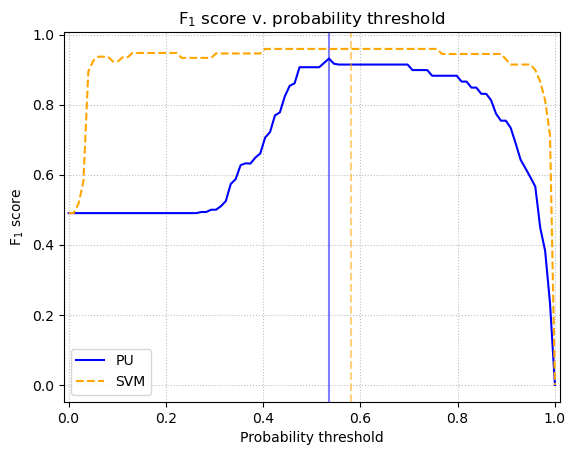

In [9]:
figure_filename = os.path.join(figures_dir, "probability_threshold")

score_func = f1_score
thresholds = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1, 1)
for model in ("PU", "SVM"):
    probs = probs_dict["All"][model]
    scores = np.zeros_like(thresholds)
    for i, threshold in enumerate(thresholds):
        score = score_func(y_test, probs >= threshold)
        scores[i] = score
    ax.plot(thresholds, scores, label=model, **(kwargs_dict[model]))
    opt_value = np.median(thresholds[scores == np.nanmax(scores)])
    ax.axvline(opt_value, 0, 1, **(kwargs_dict[model]), alpha=0.5)
    print(f"{model}: optimal threshold = {opt_value:0.2f}")

ax.set_xlim(-0.01, 1.01)
ax.grid(
    linestyle="dotted",
    color="grey",
    alpha=0.5,
)
ax.legend()
ax.set_xlabel("Probability threshold")
ylabel = r"$\mathrm{F_1}$ score"
ax.set_ylabel(ylabel)
ax.set_title(f"{ylabel} v. probability threshold")

for ext in (".pdf", ".png"):
    fig.savefig(figure_filename + ext, dpi=350, bbox_inches="tight")
